In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
training = pd.read_csv('/Users/phamlethuylinh/Desktop/Pink/train.csv')
test = pd.read_csv('/Users/phamlethuylinh/Desktop/Pink/test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

****Feature Engineering****

In [6]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

<AxesSubplot:xlabel='Age', ylabel='Count'>

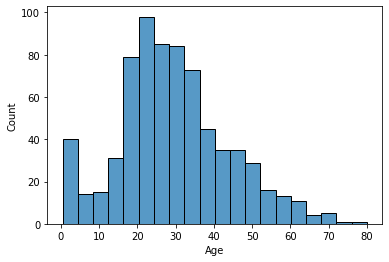

In [41]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.tile_providers import OSM
from bokeh.palettes import Category20b, Category20c, Spectral, Magma, Inferno, Plasma, Viridis, Cividis, Purples
sns.histplot(df_num.Age)

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

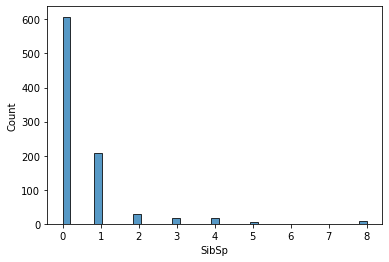

In [42]:
sns.histplot(df_num.SibSp)

<AxesSubplot:xlabel='Parch', ylabel='Count'>

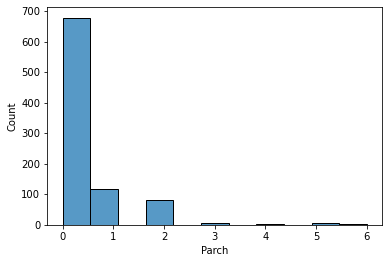

In [43]:
sns.histplot(df_num.Parch)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

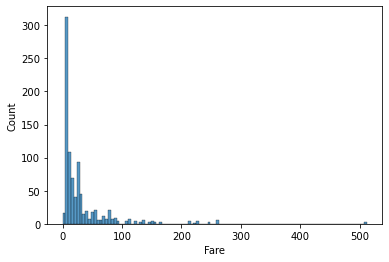

In [44]:
sns.histplot(df_num.Fare)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


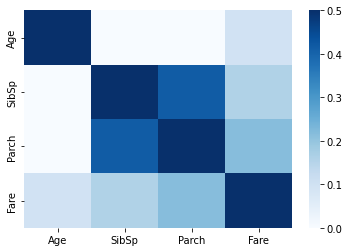

In [51]:
print(df_num.corr())
sns.heatmap(df_num.corr(), vmin=0, vmax=0.5, cmap="Blues") 
plt.show()

In [24]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


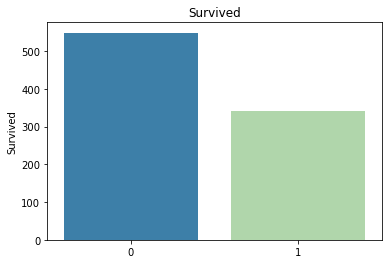

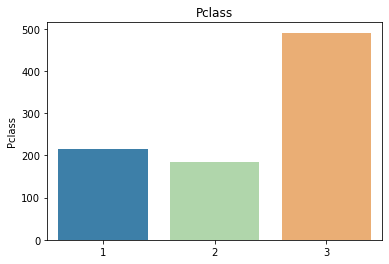

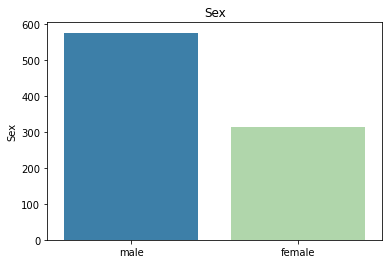

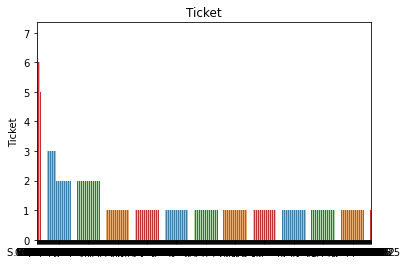

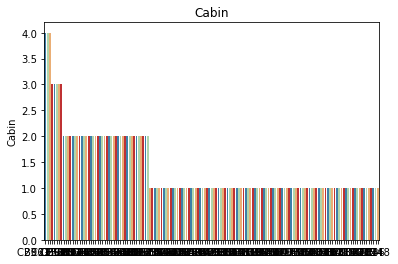

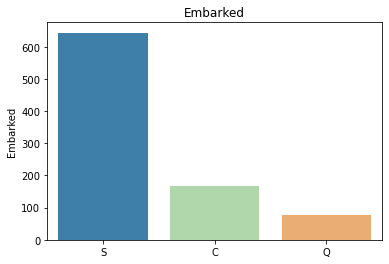

In [52]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts(), palette=Spectral[4]).set_title(i)
    plt.show()

In [7]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [59]:
print('Number of unique values in Ticket column: ' + str(len(training['Ticket'].unique())))
print('Number of unique values in Cabin column: ' + str(len(training['Cabin'].unique())))

Number of unique values in Ticket column: 681
Number of unique values in Cabin column: 148


In [57]:
pd.pivot_table(training, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [61]:
pd.pivot_table(training, values='Survived', index=['Sex', 'Pclass'])

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

In [54]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

In [55]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [11]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [12]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [13]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [14]:
#survival rate across different tyicket types 
pd.pivot_table(training,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [20]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

(889,)

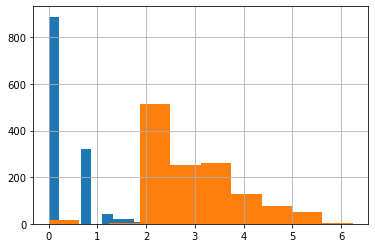

In [21]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data 
all_data.Age = all_data.Age.fillna(training.Age.median()) #fill in median for age
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [17]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [19]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


### from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())